# Notebook to evaluate anomalies after abx by matching alpha diversity by covariates

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval -c conda-forge -c defaults numpy pandas matplotlib seaborn scipy scikit-learn ipython ipykernel -y
conda activate score_eval
pip install -e .
```


## Setup

In [1]:
import os
import warnings

import pandas as pd

from src.utils_eval_score import (
    _plot_score_after_nth_abx_exposure,
    _select_samples_around_nth_abx_exposure,
    calculate_matched_metric_n_diff,
    get_scores_n_abx_info,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)
# avg. number of days per month
DAYS_PER_MONTH = 30.437

In [2]:
#### USER INPUT START
# name of the model
model_name = "saved_models_microbial_novel_alpha_div2/id-57"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "best"

# name of feature dataset used for model
ft_name = "ft_vat19_anomaly_v20240806_entero_genus"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240806"

# limit evaluation to time range up to this many months (if None no limit is set
# and all scores are evaluated)
limit_months = 24.0

# whether to group samples prior to abx exposure in analysis
group_samples = True

# how many samples prior and after abx exposure to consider
min_samples = -3.0
max_samples = 6.0

# whether to filter noabx score samples by having at least 1 obs prior to cutoff
no_filter = True

# whether to display diet info after 1st, 2nd, 3rd abx exposure plots
display_diet_info = False

# whether to have max. resolution of 0.5 months or not
max_resolution = False

# scaling factor options:
scaling_factors_used = True

# if scaling_factors_used is True, then the following options are required:
# non-centered = "nc_std" or centered = "std"
stddev_type = "nc_std"
# moving average window size: 30 or 10
moving_avg = 10
# whether to remove duplicates: "--RD-True" or "--RD-False"
duplicates = "--RD-True"
# using lower bound of 1 for SFs: "lower_bound-1" or ""
lower_bound = ""

# variables to perform matching by
matching_vars = ["month_bin", "delivery_mode", "diet_milk", "diet_weaning"]

#### USER INPUT END

## Read and prep data

In [3]:
base_path = f"../data/{model_name}/anomaly_detection/"

res_n_group = f"g{str(group_samples)[0]}_maxres{str(max_resolution)[0]}"

if scaling_factors_used:
    print("Scaling factors used.")
    folder_name = f"using-SF_{stddev_type}_z_scores--moving_avg-{moving_avg}-cummax{lower_bound}{duplicates}"

    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/{folder_name}/"
    evaluation_path = f"{base_path}evaluation_{point_to_evaluate}_overall_{res_n_group}_{stddev_type}_ma{moving_avg}{duplicates.replace('-', '_').lower()}/"
else:
    scores_path = f"{base_path}scores_{point_to_evaluate}_normal/"
    evaluation_path = (
        f"{base_path}evaluation_{point_to_evaluate}_overall_{res_n_group}_no_scaling/"
    )
if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)


Scaling factors used.


In [4]:
noabx_train, noabx_val, abx_scores_flat, abx_df, abx_age_at_all = get_scores_n_abx_info(
    scores_path, ft_name, limit_months, abx_ts_name, no_filter=no_filter
)


## Matching

### Unmatched 1st abx

effects observed are confounded by many covariates

Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx1st_div_alpha_faith_pd.pdf


'../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx1st_div_alpha_faith_pd.pdf'

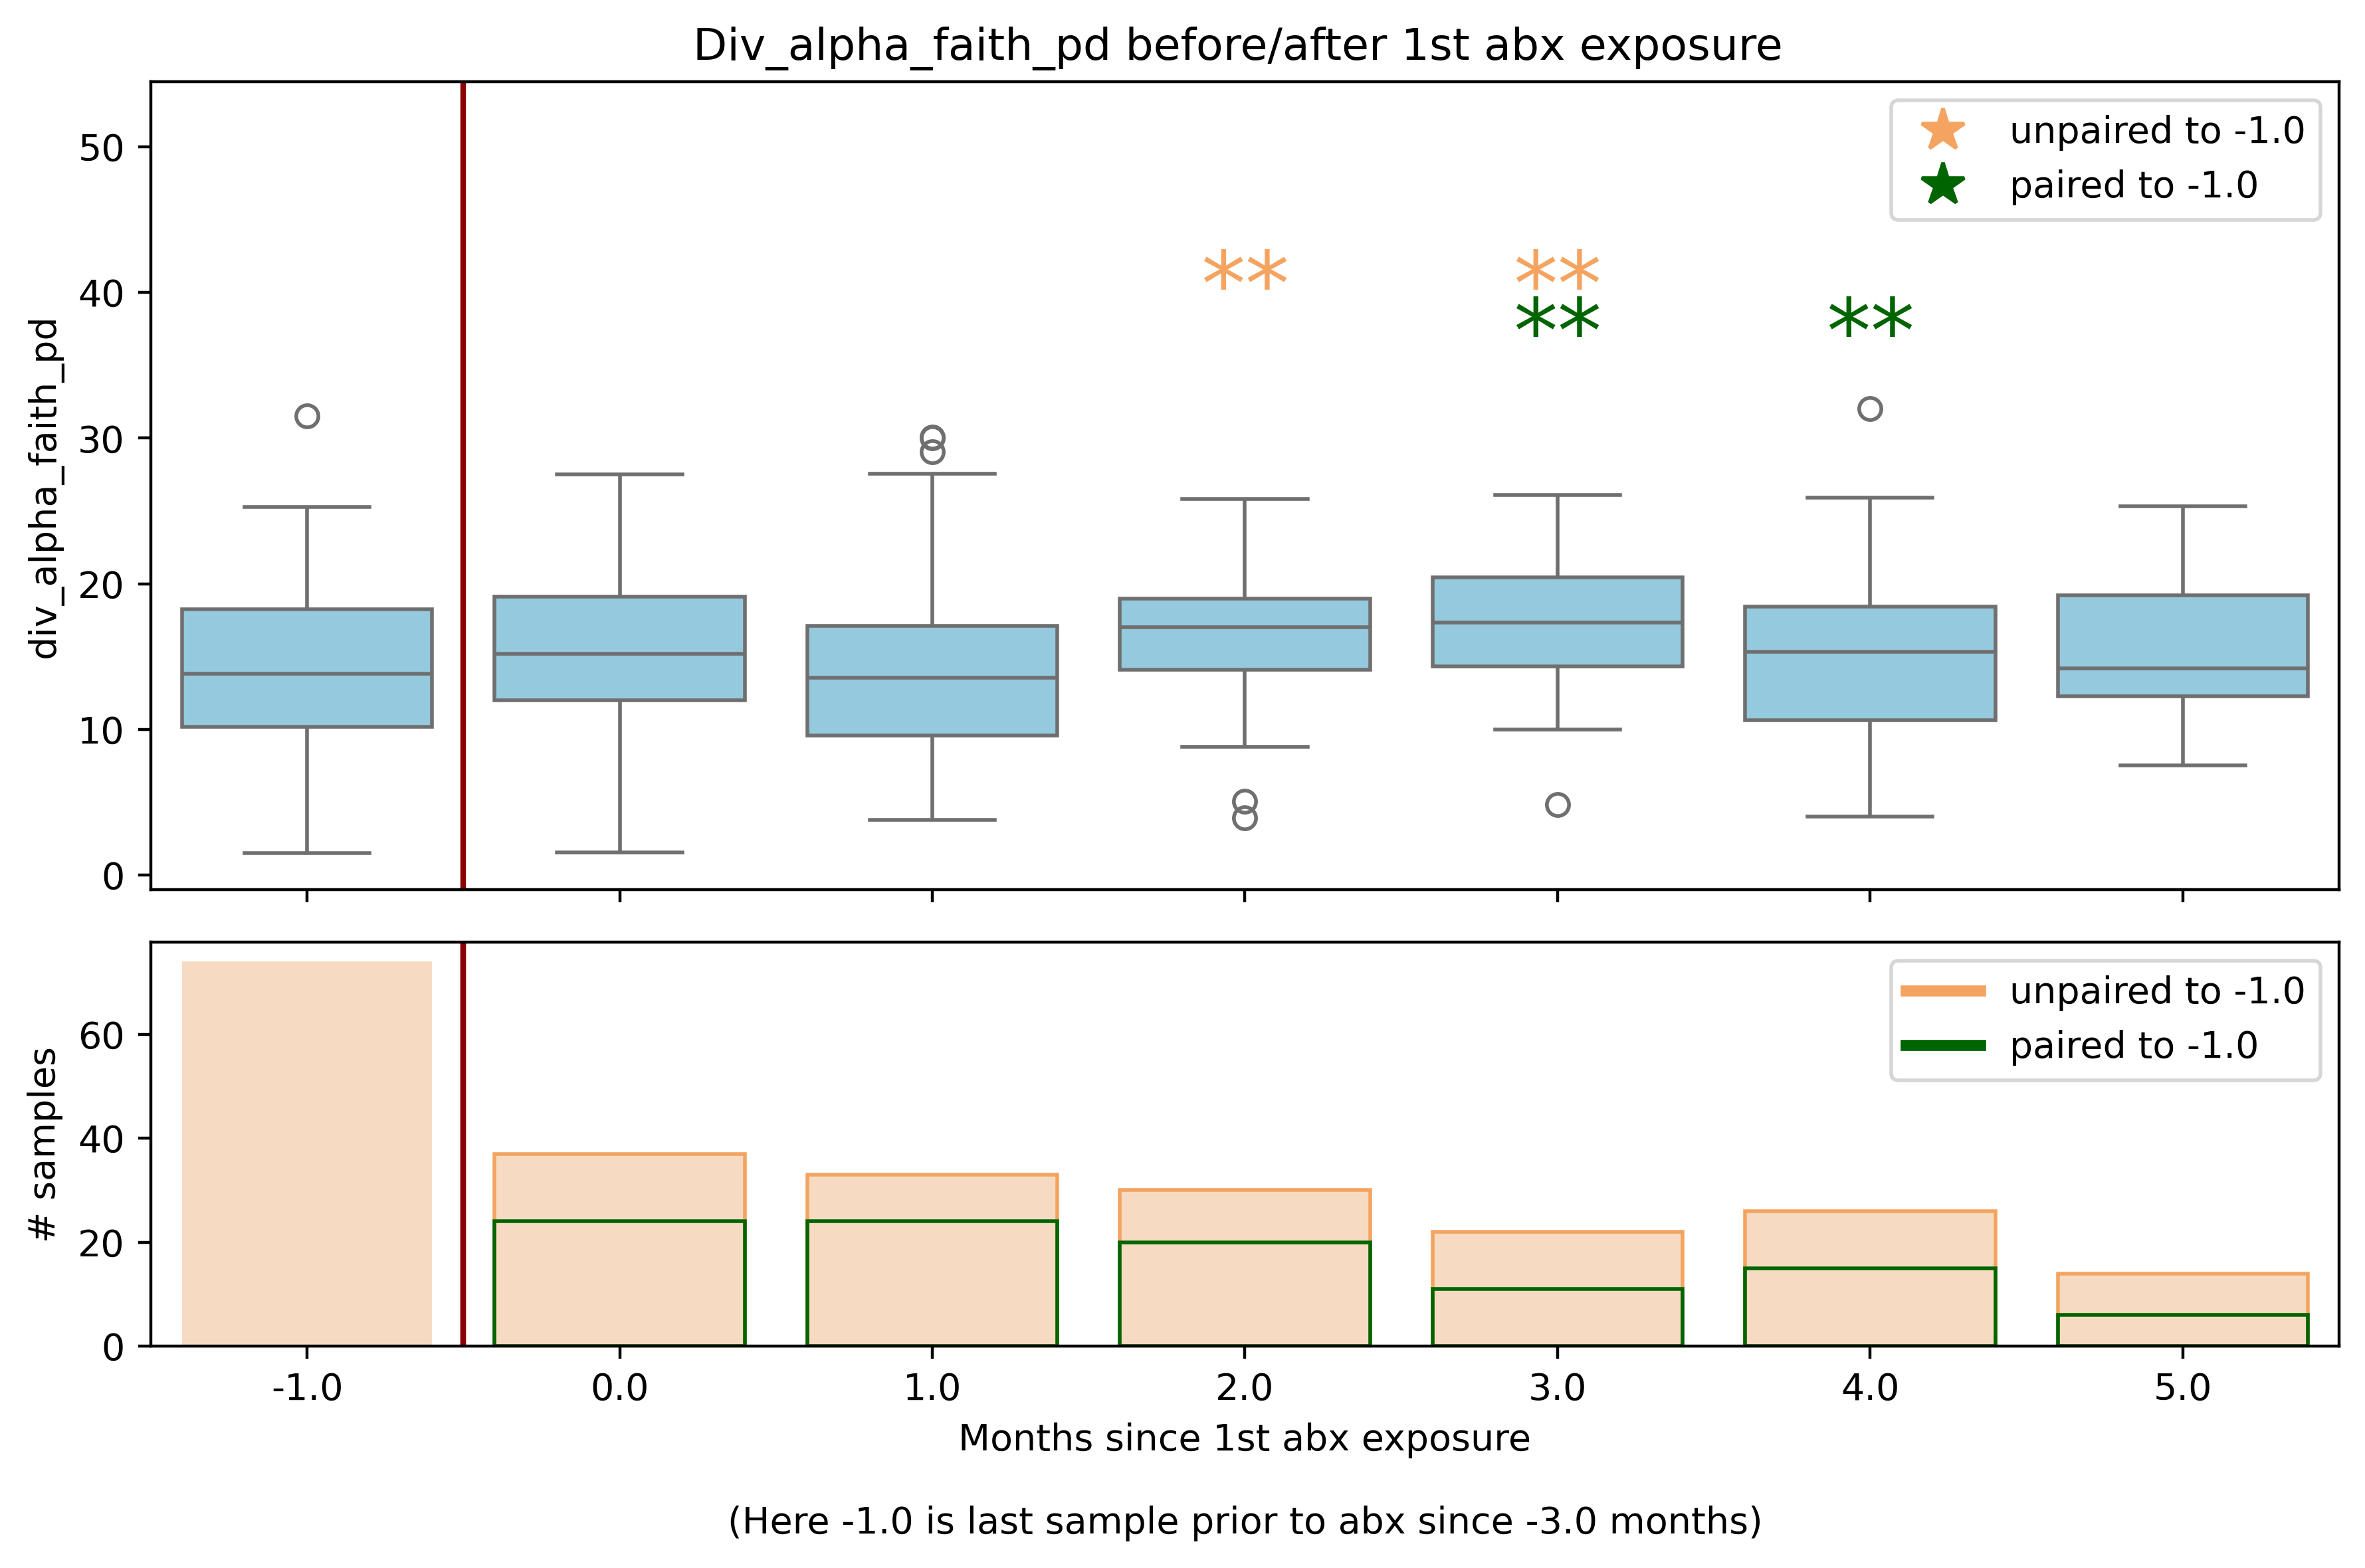

In [5]:
# without proper matching little effect from abx visible - probably confounded
# by age, diet, delivery mode
n = 1
metric = "div_alpha_faith_pd"

# only select samples that are around n-th abx exposure
abx_nth_samples = _select_samples_around_nth_abx_exposure(
    abx_scores_flat,
    abx_df,
    n=n,
    min_samples=min_samples,
    max_samples=max_samples,
    group_samples=group_samples,
    score_var=metric,
    max_resolution=max_resolution,
)

# create boxplot of this metric
_plot_score_after_nth_abx_exposure(
    abx_nth_samples,
    x_axis="diff_age_nth_abx",
    y_axis=metric,
    n=n,
    path_to_save=evaluation_path,
    flag=metric,
    min_samples=min_samples,
    max_samples=max_samples,
    max_resolution=max_resolution,
    grouped_samples=group_samples,
)

### Perform matching

In [6]:
noabx = pd.concat([noabx_train, noabx_val])

for metric in [
    "div_alpha_faith_pd",
    # "div_alpha_observed_features",
    # "div_alpha_shannon",
]:
    abx_scores_flat = calculate_matched_metric_n_diff(
        metric, abx_scores_flat, noabx, matching_vars
    )

Number of samples disregarded because of lacking reference in noabx: 2


### Matched: 1st to 3rd abx exposure effect on Faith PD 

Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx1st_Δ matched alpha diversity.pdf
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx2nd_Δ matched alpha diversity.pdf
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/evaluation_best_overall_gT_maxresF_nc_std_ma10__rd_true/score_after_abx3rd_Δ matched alpha diversity.pdf


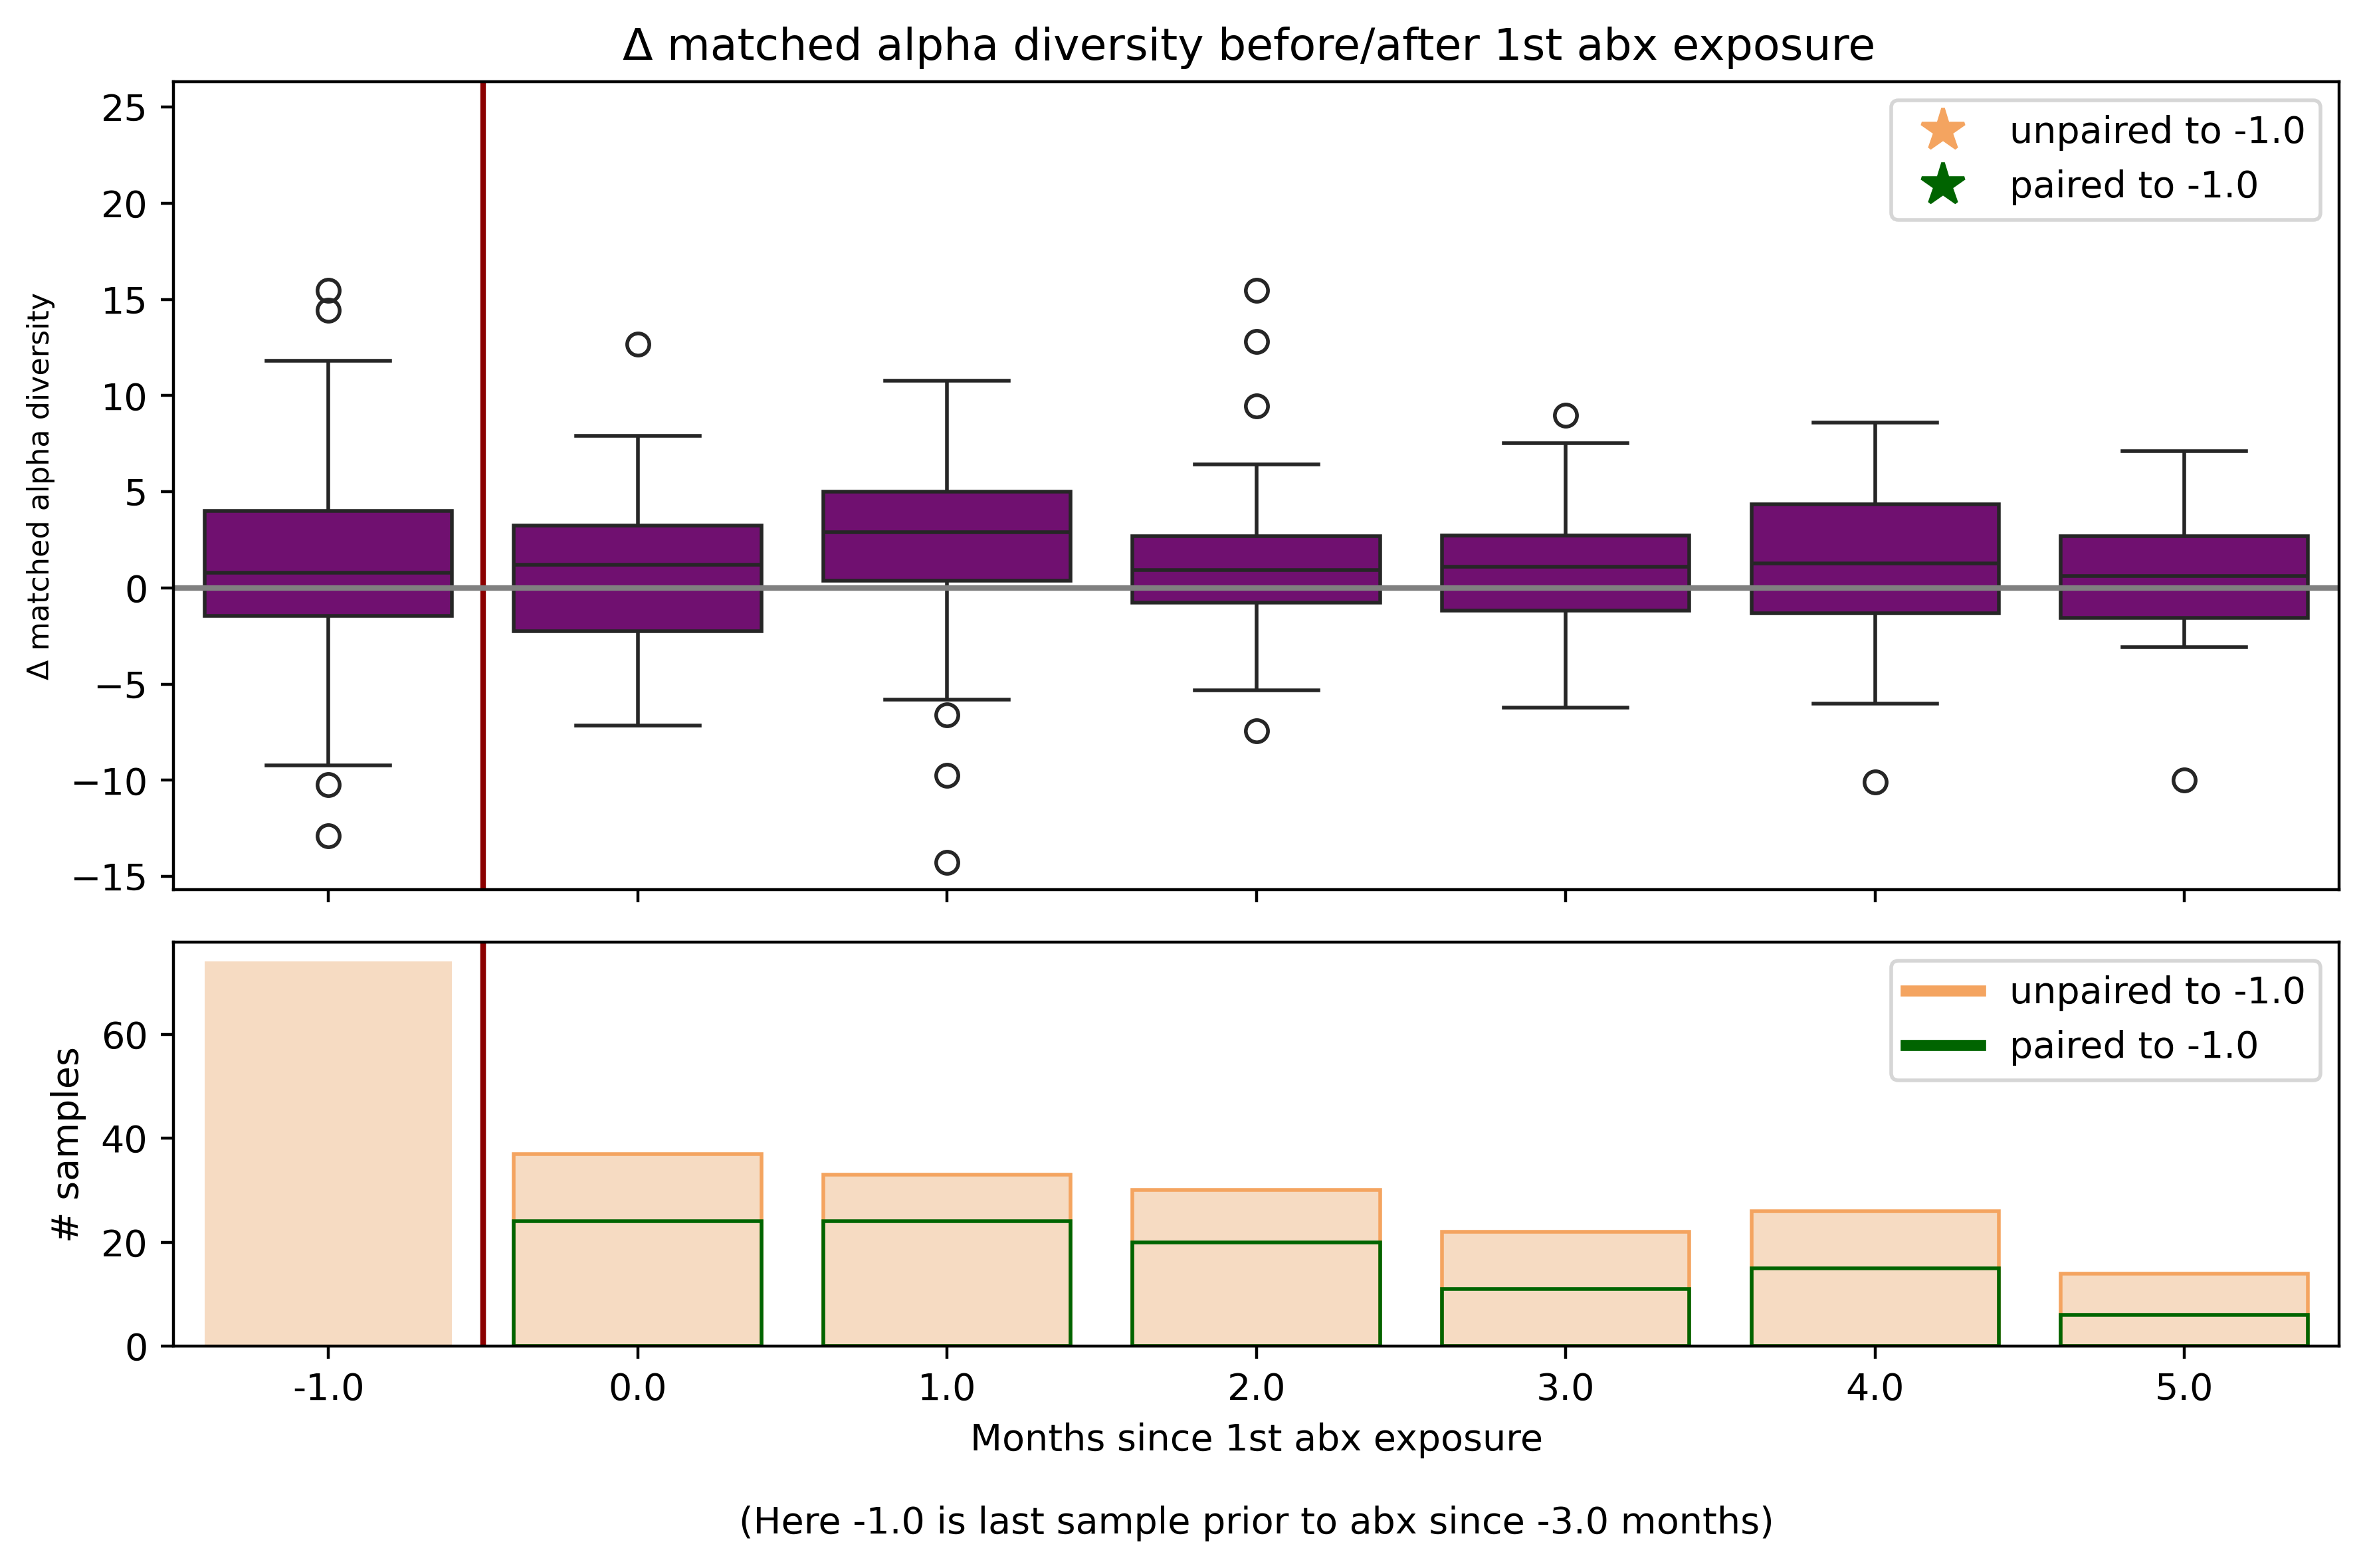

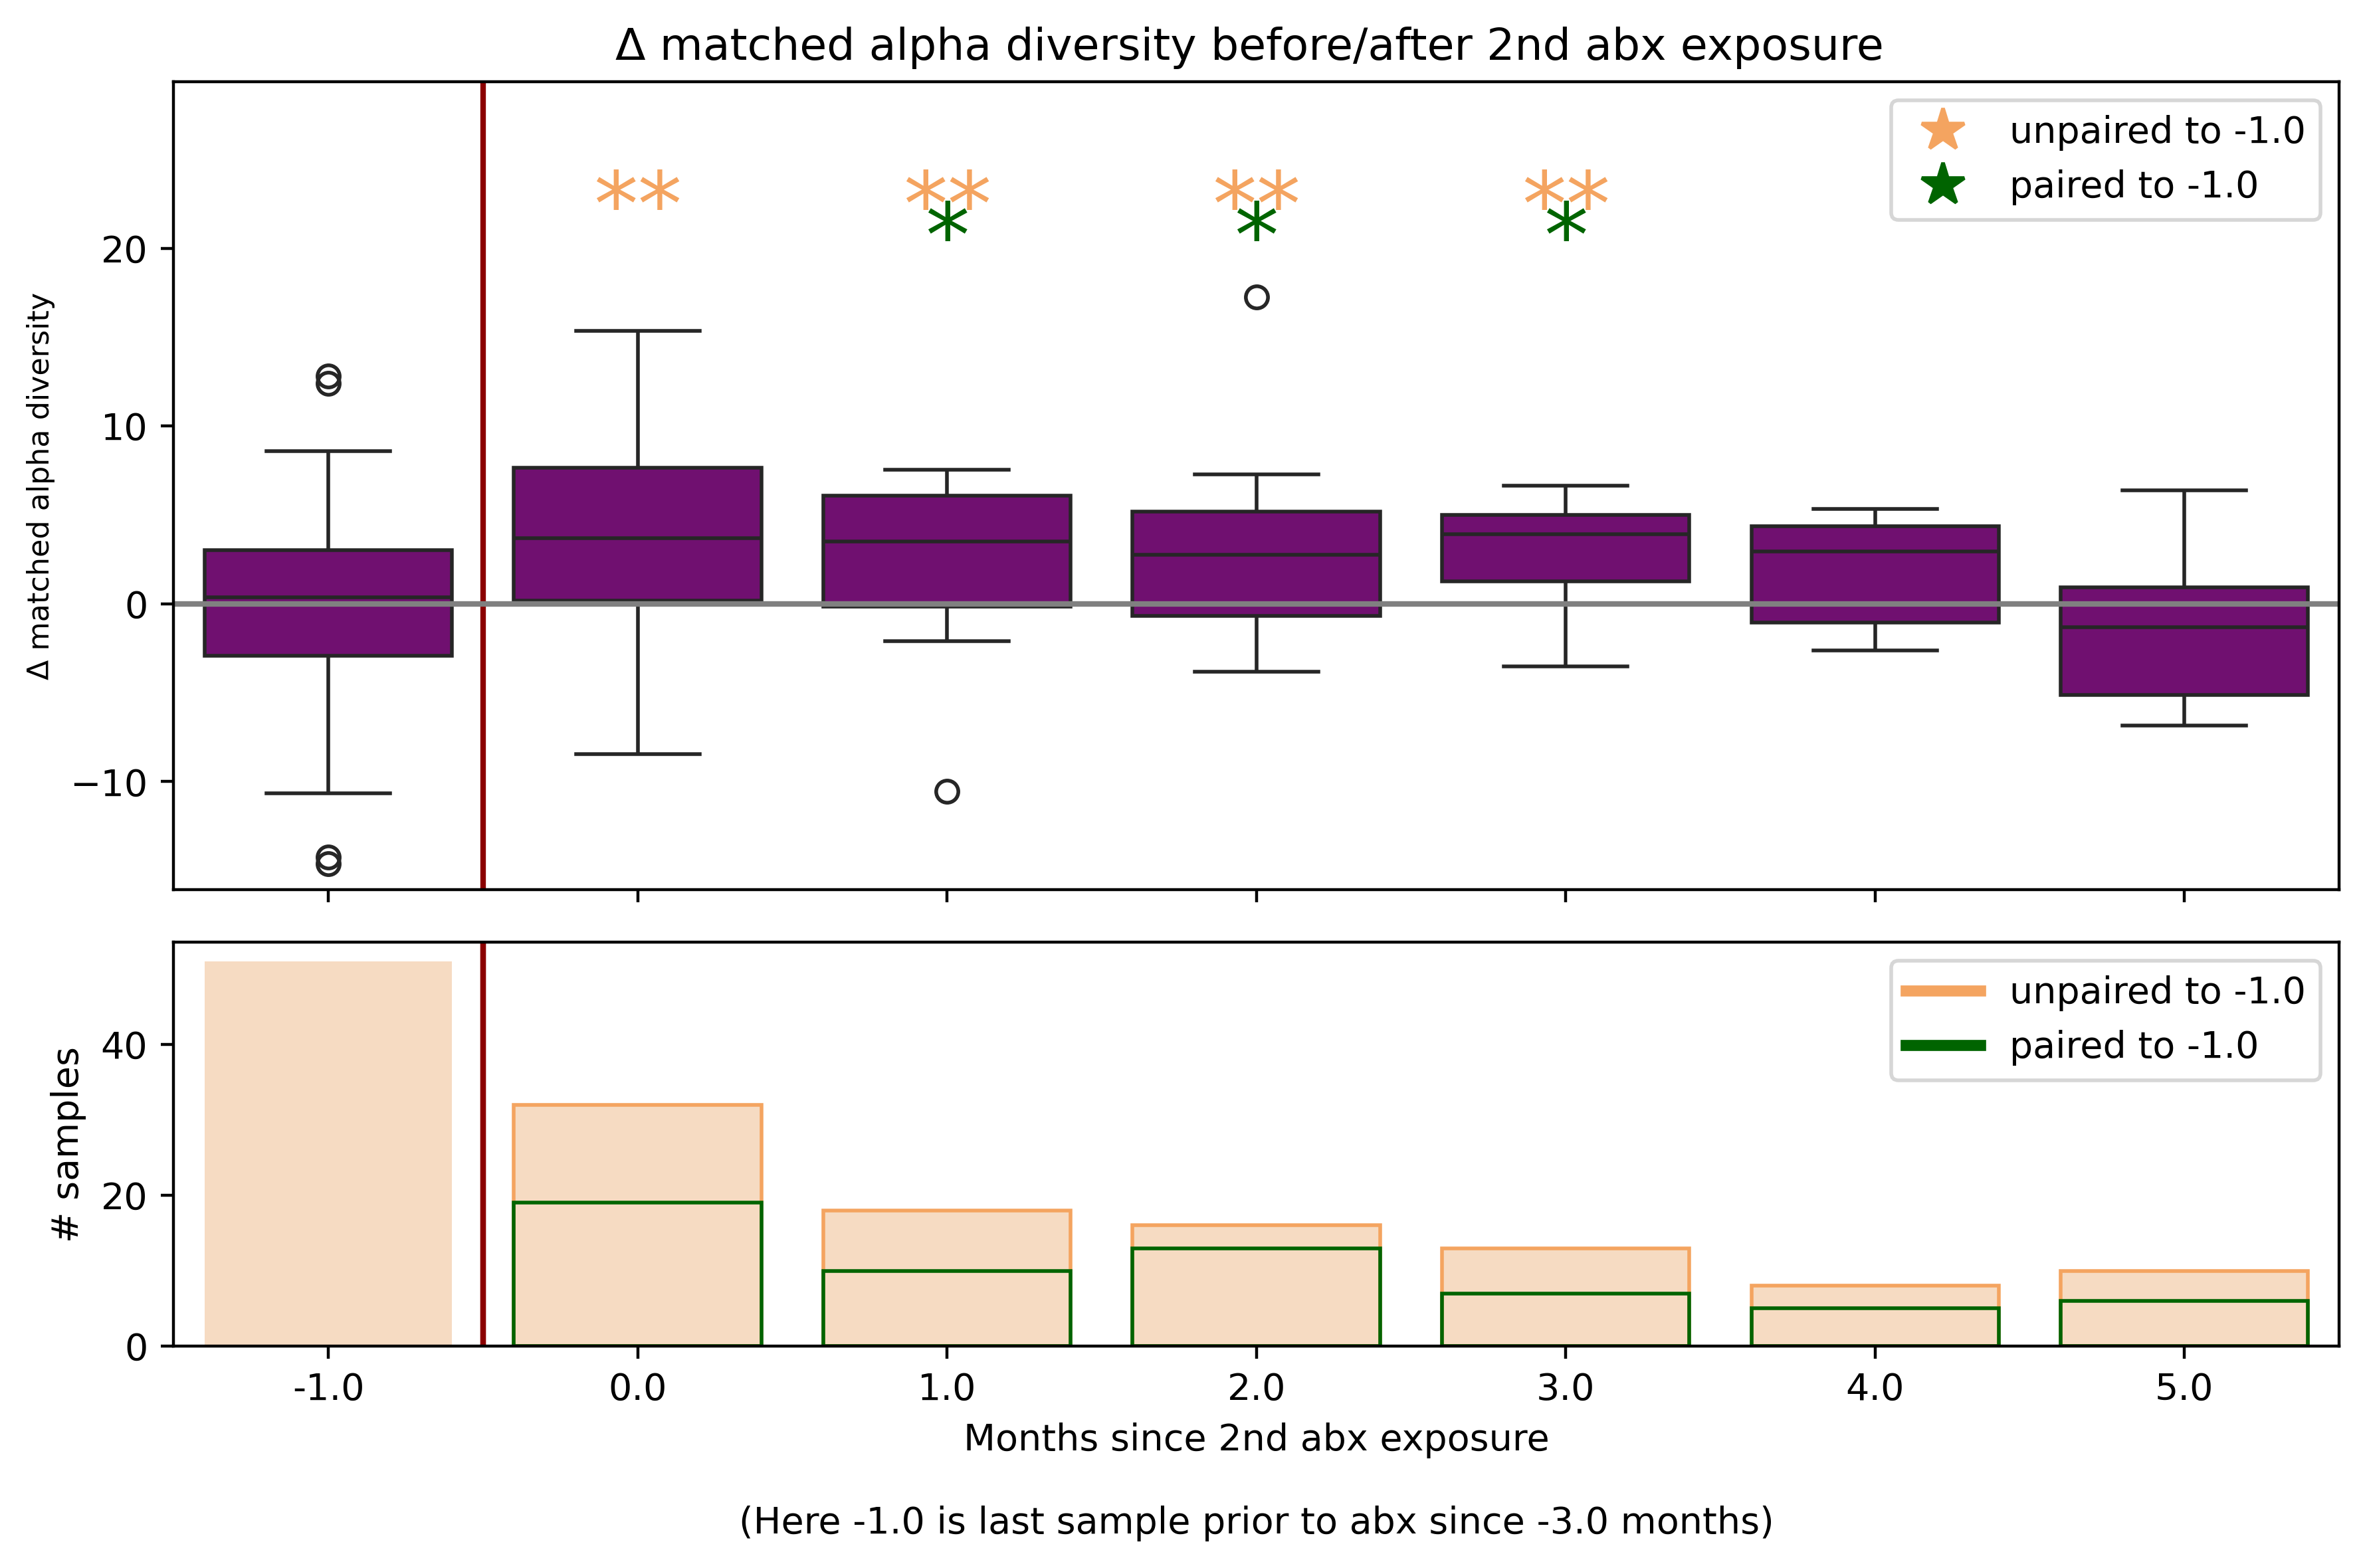

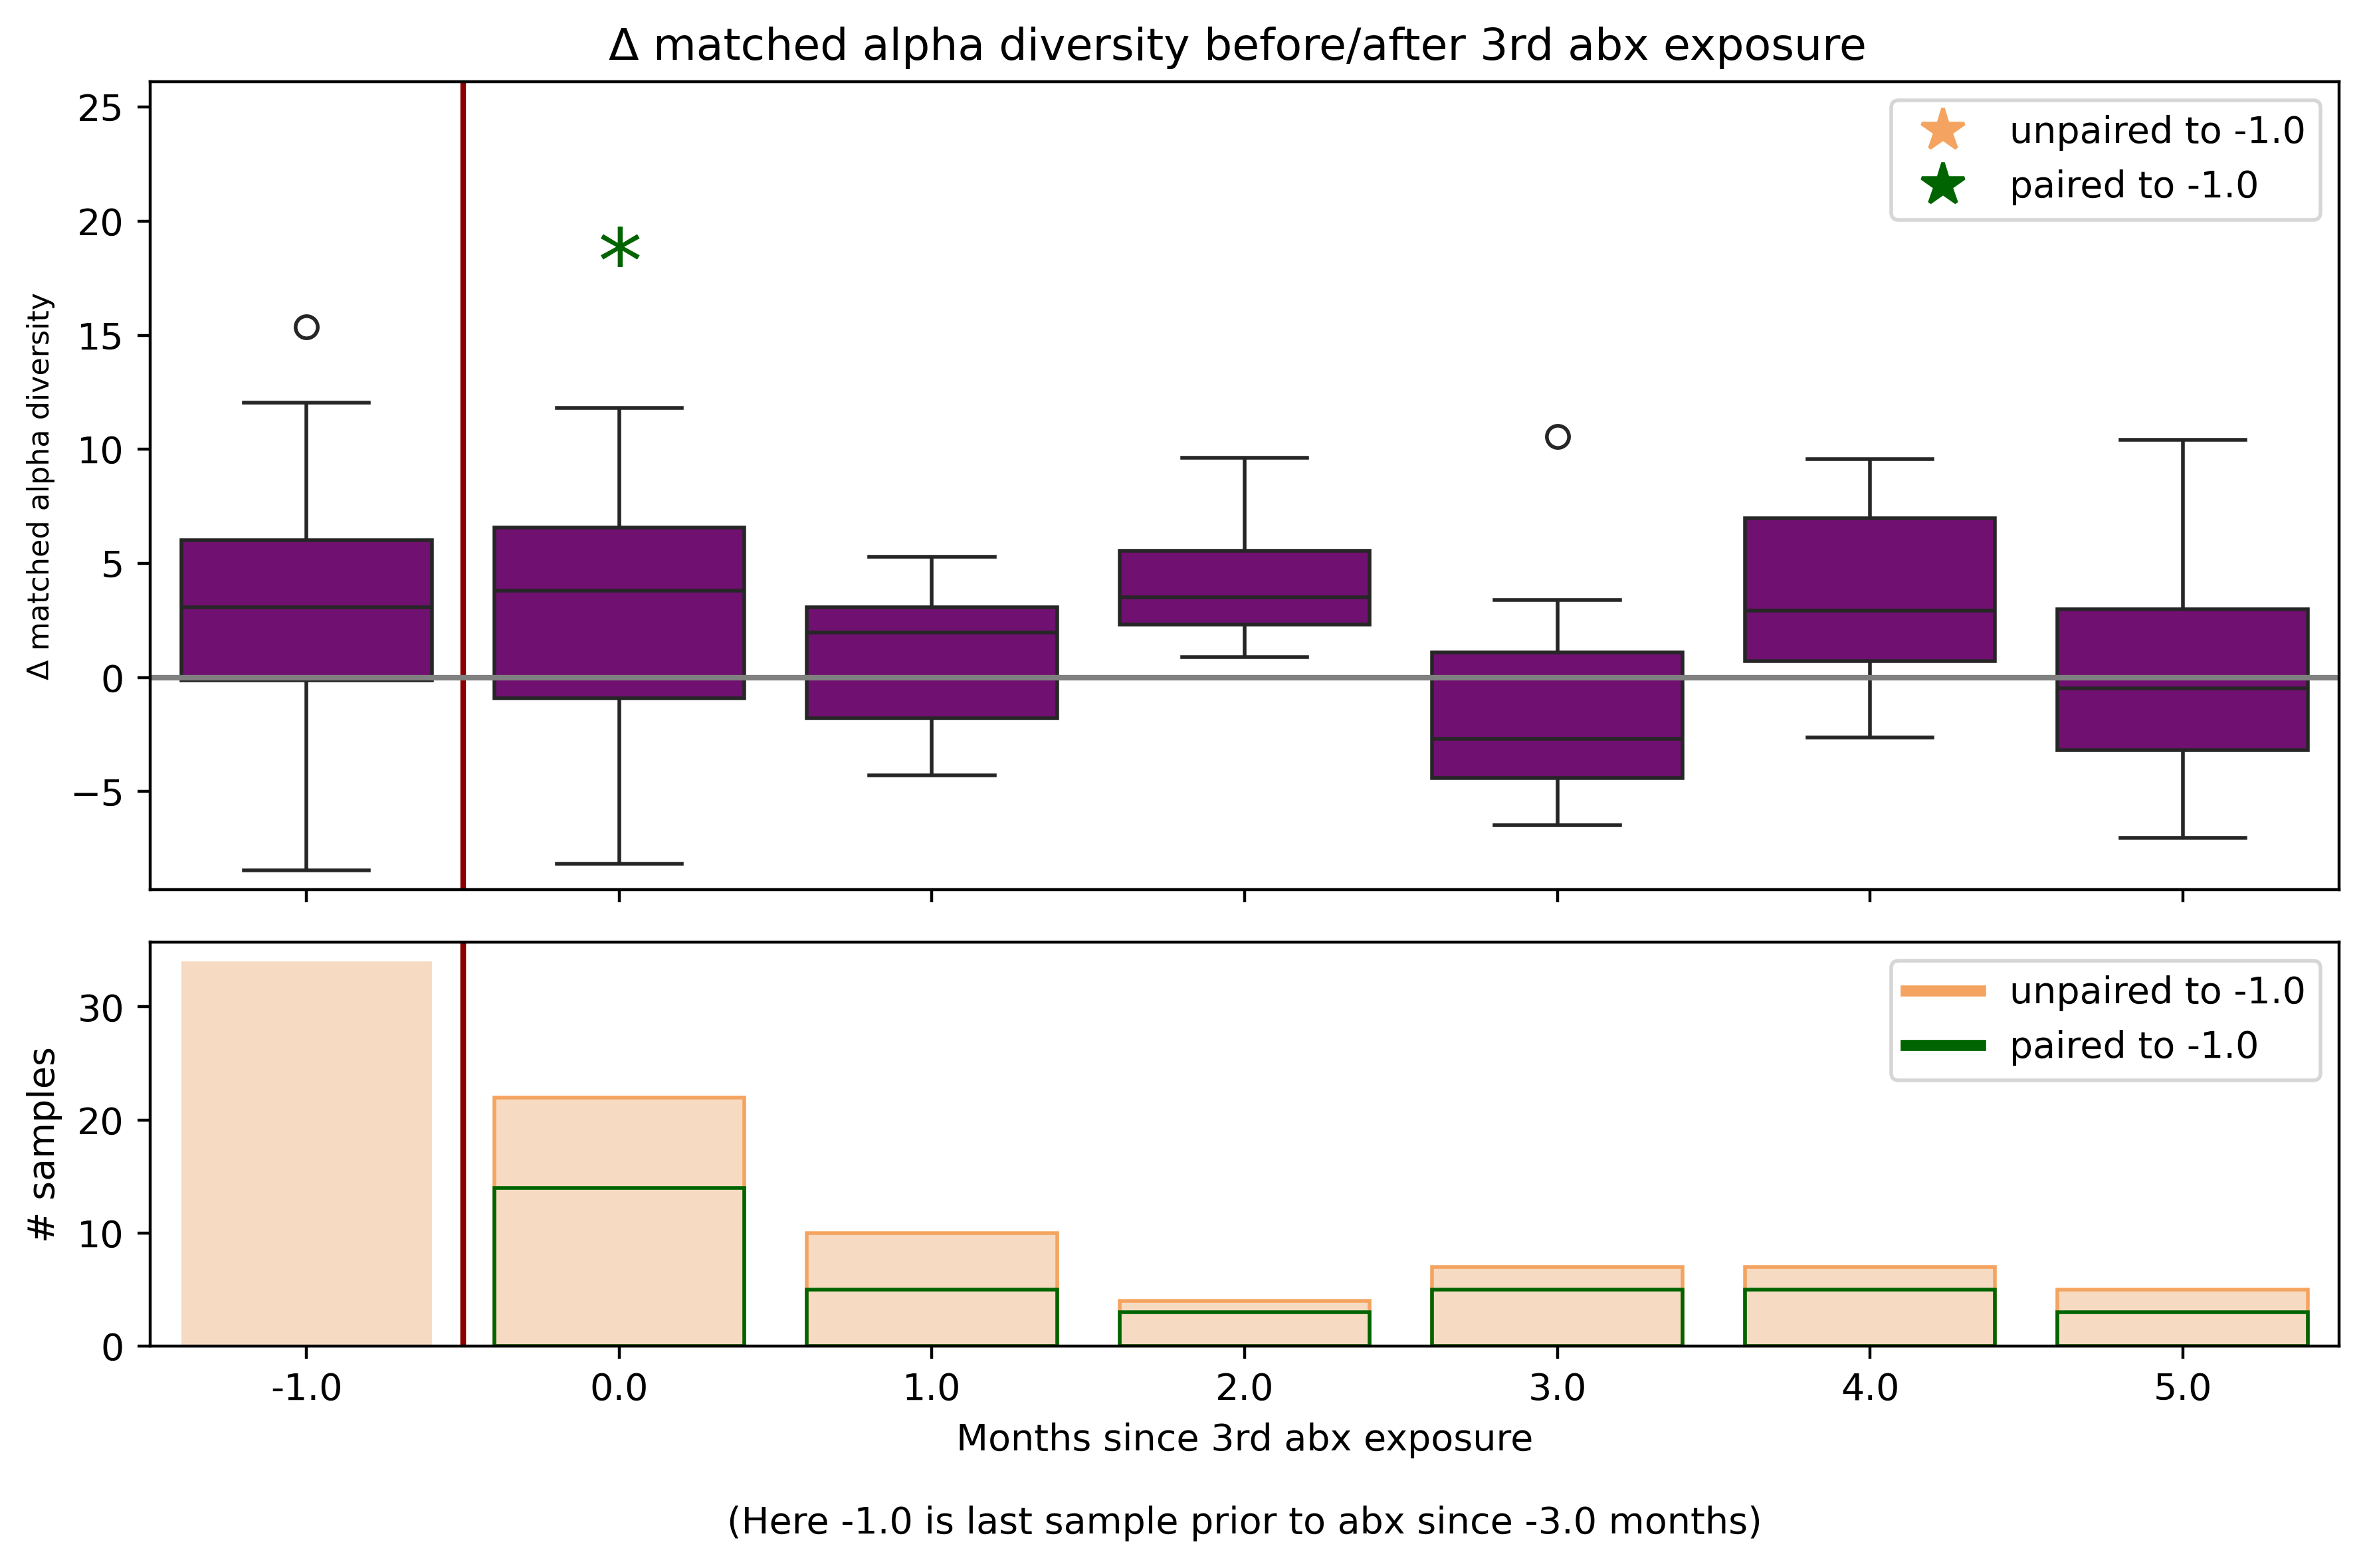

In [7]:
metric = "div_alpha_faith_pd"

for n in [1, 2, 3]:
    plot_metric = "Δ matched alpha diversity"

    # only select samples that are around n-th abx exposure
    abx_nth_samples = _select_samples_around_nth_abx_exposure(
        abx_scores_flat,
        abx_df,
        n=n,
        min_samples=min_samples,
        max_samples=max_samples,
        group_samples=group_samples,
        score_var=plot_metric,
        max_resolution=max_resolution,
    )
    # create boxplot of this metric
    _plot_score_after_nth_abx_exposure(
        abx_nth_samples,
        x_axis="diff_age_nth_abx",
        y_axis=plot_metric,
        n=n,
        path_to_save=evaluation_path,
        flag=plot_metric,
        min_samples=min_samples,
        max_samples=max_samples,
        max_resolution=max_resolution,
        grouped_samples=group_samples,
        boxplot_color="purple",
    )

Conclusion:
* By plotting simply diversity after abx exposure across all age ranges and other covariates the effects of abx exposure are less distinct than after matching by covariates.

Recommendation drawn from these insights for modelling:
* Recommendation to use **Faith PD** as alpha metrics in modelling (since all alpha diversity metrics capture similar trends and this one also includes phylogenetic information).
* Recommendation to use **path dependent model**: This analysis aimed to see how long the antibiotics effect lasts on the microbiome, particularly the alpha diversity metric in our particular dataset. The analysis shows that at least for the 1st and 2nd antibiotics exposure the anomaly effect lasts for more than one timepoint. So there seem to be non-Markovian dynamics in the anomaly.